In [1]:
#Импорт необходимых библиотек

import io
import time
import torch
import torchvision
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

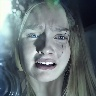

In [3]:
#Сохранение данных

data = pd.read_parquet('Affect_net_short_train.parquet')
imageStream = io.BytesIO(data['image'][1]['bytes'])
imageFile = Image.open(imageStream)
imageFile

In [4]:
#Функция для преобразования картинок в тензоры и ее применение

def convert_to(image_bytes):
    imageStream = io.BytesIO(image_bytes['bytes'])
    imageFile = Image.open(imageStream)
    return torchvision.transforms.functional.pil_to_tensor(imageFile)

data['tensor'] = data['image'].apply(convert_to)
data

,image,label,tensor
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,4,"[[[tensor(198, dtype=torch.uint8), tensor(200,..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,6,"[[[tensor(241, dtype=torch.uint8), tensor(245,..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3,"[[[tensor(74, dtype=torch.uint8), tensor(73, d..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2,"[[[tensor(133, dtype=torch.uint8), tensor(127,..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3,"[[[tensor(76, dtype=torch.uint8), tensor(74, d..."
...,...,...,...
23228,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[[[tensor(7, dtype=torch.uint8), tensor(12, dt..."
23229,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2,"[[[tensor(250, dtype=torch.uint8), tensor(249,..."
23230,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2,"[[[tensor(236, dtype=torch.uint8), tensor(244,..."
23231,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,7,"[[[tensor(90, dtype=torch.uint8), tensor(90, d..."


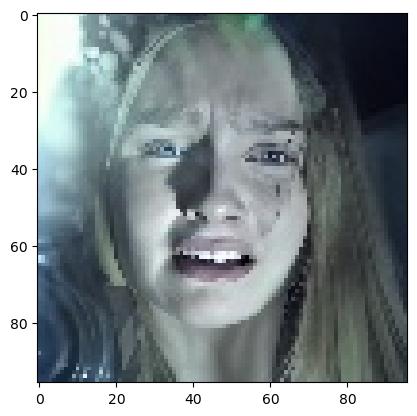

In [6]:
#Пример картинки из датасета
plt.imshow(data.iloc[1]['tensor'].permute(1,2,0))

In [7]:
#Разбиение данных на тестовые и тренировочные
X = data['tensor']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None, device='cpu'):
        self.X = X
        self.y = y
        self.transform = transform
        self.device = device #Выбор устройства, на котором будут производиться вычисления

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X.iloc[idx].float()/255 #приводим к значениям [0..1]
        y = torch.tensor(self.y.iloc[idx])
        if self.transform:
            X = self.transform(X)
        if self.device == 'cpu':
            return X, y
        return X.to(self.device), y.to(self.device)

In [9]:
#Аугментация
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

In [23]:
#Создание объекта класса MyDataset с учетом аугментации
test_dataset = MyDataset(X_test, y_test, transform=transform)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [12]:
#Первая  модель с простой архитектурой
class MyCNNModel(torch.nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 8, kernel_size=10, stride=5, padding=4)
        self.bn1 = torch.nn.BatchNorm2d(8)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=6, stride=3, padding=4)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.relu2 = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=6, stride=3)
        self.fc1 = torch.nn.Linear(256, 128)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.tanh  = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(128, 8)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) #приведение к плоскому вектору
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x

In [13]:
#Вторая модель, архитектура схожа с VGG-16
class MyCNNModel1(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(MyCNNModel1, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Linear(4608, hidden_sizes[0]),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_sizes[0], num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) #приведение к плоскому вектору
        out = self.layer5(out)
        
        return out

In [14]:
#Третья модель - упрощенная и оптимальная
class MyCNNModel2(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(MyCNNModel2, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Linear(512 * 1 * 1, hidden_sizes[0]),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_sizes[0], num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) 
        out = out.view(out.size(0), -1) #приведение к плоскому вектору
        out = self.layer5(out)
        
        return out

In [19]:
#Цикл обучения
kf = KFold(n_splits=4) #разделение данных на 4 части с помощью кросс-валидации
epoch_losses = {}
verbose = 5
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    torch.cuda.empty_cache()
    model = MyCNNModel().cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) 
    train_dataset = MyDataset(X_train.iloc[train_index], y_train.iloc[train_index], transform=transform, device='cuda:0')
    validate_dataset = MyDataset(X_train.iloc[test_index], y_train.iloc[test_index], transform=transform, device='cpu')
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=16, shuffle=False)
    
    epochs = 25
    epoch_loss = []
    
    start_time = time.time()
    print(f'Fold {i+1}')
    for epoch in range(epochs):
        
        val_losses = []
        temp_loss = 0
        
        losses = []
        model.train()
        for X, y in tqdm(train_loader, desc=f'Epoch {epoch+1}', position=0, leave=False):
            optimizer.zero_grad()  
            y_pred = model.to('cuda:0').forward(X)        
            curr_loss = criterion(y_pred, y)
            losses.append(curr_loss)
            curr_loss.backward()
            optimizer.step()   

            val_losses.append(curr_loss.item())
            torch.cuda.empty_cache()

        if epoch % verbose == 0:
            with torch.no_grad():
                model.eval()
                y_pred = torch.tensor([])
                y_true = torch.tensor([])
                for X, y in tqdm(validate_loader, desc='Validate', leave=False):
                    pred = model.to('cpu').forward(X)
                    curr_loss = criterion(pred, y).item()
                    y_pred = torch.hstack((y_pred, pred.argmax(dim=1)))
                    y_true = torch.hstack((y_true, y.to('cpu')))
                    
                print(f"Epoch {epoch+1} | Loss: {curr_loss} | Accuracy: {accuracy_score(y_true, y_pred)} | F1-score {f1_score(y_true, y_pred, average='weighted')}")
                
        temp_loss = sum(val_losses) / len(val_losses)
        epoch_loss.append(temp_loss)
    fold_time = time.time() - start_time
    epoch_losses[i] = {'losses': epoch_loss, 'time': fold_time}

Fold 1


Epoch 1 | Loss: 1.8033177852630615 | Accuracy: 0.18205293737895417 | F1-score 0.06953259758137295


Epoch 6 | Loss: 1.4448381662368774 | Accuracy: 0.3088013772326232 | F1-score 0.2538081688313807


Epoch 11 | Loss: 1.4698344469070435 | Accuracy: 0.32537120723047125 | F1-score 0.27659911815168564


Epoch 16 | Loss: 1.1585437059402466 | Accuracy: 0.38562513449537333 | F1-score 0.33064022996262177


Epoch 21 | Loss: 1.1276136636734009 | Accuracy: 0.42844846137292875 | F1-score 0.38502152391014927


Fold 2


Epoch 1 | Loss: 2.1254820823669434 | Accuracy: 0.22616741984075747 | F1-score 0.14854015357948774


Epoch 6 | Loss: 1.602980375289917 | Accuracy: 0.2920163546374005 | F1-score 0.20316440612553255


Epoch 11 | Loss: 1.4914968013763428 | Accuracy: 0.2948138584032709 | F1-score 0.19662902955006475


Epoch 16 | Loss: 1.7401455640792847 | Accuracy: 0.35829567462879275 | F1-score 0.31102755364479484


Epoch 21 | Loss: 1.4761847257614136 | Accuracy: 0.40111900150634816 | F1-score 0.3443154620391725


Fold 3


Epoch 1 | Loss: 2.2450709342956543 | Accuracy: 0.17283684890228154 | F1-score 0.053596295220764756


Epoch 6 | Loss: 1.2930275201797485 | Accuracy: 0.3080068876452863 | F1-score 0.19568103879498505


Epoch 11 | Loss: 1.4463645219802856 | Accuracy: 0.3564356435643564 | F1-score 0.2853524062690423


Epoch 16 | Loss: 1.3201446533203125 | Accuracy: 0.38678433060697376 | F1-score 0.3603864361031616


Epoch 21 | Loss: 1.3875012397766113 | Accuracy: 0.42165303486870426 | F1-score 0.3966226884521019


Fold 4


Epoch 1 | Loss: 1.9992328882217407 | Accuracy: 0.25053809728798965 | F1-score 0.15520206281908216


Epoch 6 | Loss: 1.63382089138031 | Accuracy: 0.2985363753766681 | F1-score 0.2399456523434225


Epoch 11 | Loss: 1.8665465116500854 | Accuracy: 0.31683168316831684 | F1-score 0.25766328197732585


Epoch 16 | Loss: 1.7400484085083008 | Accuracy: 0.36612139474817046 | F1-score 0.33538921053785753


Epoch 21 | Loss: 2.0842761993408203 | Accuracy: 0.39862247094274644 | F1-score 0.35254768037884887


In [20]:
#Оценка модели

model.eval() #Модель переходит в режим инференса
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model.to('cpu')(X)
        predicted = torch.argmax(outputs, dim=1)
        y_pred += list(predicted.cpu().numpy())
        y_true += list(y)

In [21]:
#Вывод метрик

accuracy = accuracy_score(list(map(lambda x: x.cpu(), y_true)), y_pred)
print(f"Accuracy on test data: {accuracy}")
f1 = f1_score(list(map(lambda x: x.cpu(), y_true)), y_pred, average='weighted')
print(f"F1 on test data: {f1}")

Accuracy on test data: 0.43017000215192597
F1 on test data: 0.39859183680353194


In [22]:
print(f'Среднее время обучения: {sum([epoch_losses[key]["time"] for key in range(4)])/4/60:.2f} минут')

Среднее время обучения: 20.28 минут


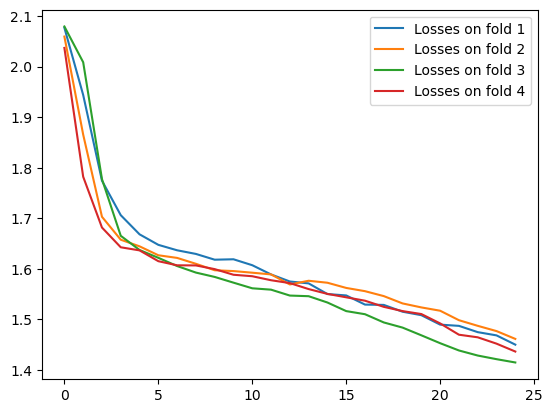

In [25]:
for i in range(4):
    plt.plot(epoch_losses[i]['losses'], label=f"Losses on fold {i + 1}")
plt.legend()
plt.show()

In [31]:
#Обучение второй модели

kf = KFold(n_splits=4)
epoch_losses = {}
verbose = 5
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    torch.cuda.empty_cache()
    hidden_sizes = [512]
    model = MyCNNModel1(3, 8).cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) 
    train_dataset = MyDataset(X_train.iloc[train_index], y_train.iloc[train_index], transform=transform, device='cuda:0')
    validate_dataset = MyDataset(X_train.iloc[test_index], y_train.iloc[test_index], transform=transform, device='cpu')
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=16, shuffle=False)
    
    epochs = 25
    epoch_loss = []
    
    start_time = time.time()
    print(f'Fold {i+1}')
    for epoch in range(epochs):
        
        val_losses = []
        temp_loss = 0
        
        losses = []
        model.train()
        for X, y in tqdm(train_loader, desc=f'Epoch {epoch+1}', position=0, leave=False):
            optimizer.zero_grad()  
            y_pred = model.to('cuda:0').forward(X)        
            curr_loss = criterion(y_pred, y)
            losses.append(curr_loss)
            curr_loss.backward()
            optimizer.step()   

            val_losses.append(curr_loss.item())
            torch.cuda.empty_cache()

        if epoch % verbose == 0:
            with torch.no_grad():
                model.eval()
                y_pred = torch.tensor([])
                y_true = torch.tensor([])
                for X, y in tqdm(validate_loader, desc='Validate', leave=False):
                    pred = model.to('cpu').forward(X)
                    curr_loss = criterion(pred, y).item()
                    y_pred = torch.hstack((y_pred, pred.argmax(dim=1)))
                    y_true = torch.hstack((y_true, y.to('cpu')))
                    
                print(f"Epoch {epoch+1} | Loss: {curr_loss} | Accuracy: {accuracy_score(y_true, y_pred)} | F1-score {f1_score(y_true, y_pred, average='weighted')}")
                
        temp_loss = sum(val_losses) / len(val_losses)
        epoch_loss.append(temp_loss)
    fold_time = time.time() - start_time
    epoch_losses[i] = {'losses': epoch_loss, 'time': fold_time}

Fold 1


Epoch 1 | Loss: 1.2913076877593994 | Accuracy: 0.46653755110824185 | F1-score 0.4423815894844007


Epoch 6 | Loss: 0.6273186802864075 | Accuracy: 0.5719819238218206 | F1-score 0.5601396839311602


Epoch 11 | Loss: 0.523844838142395 | Accuracy: 0.6109317839466323 | F1-score 0.6030899201222545


Epoch 16 | Loss: 0.36192771792411804 | Accuracy: 0.6191091026468689 | F1-score 0.617843766435076


Epoch 21 | Loss: 0.5050280690193176 | Accuracy: 0.6210458360232408 | F1-score 0.6163761753804169


Fold 2


Epoch 1 | Loss: 1.616916298866272 | Accuracy: 0.33978911125457284 | F1-score 0.2675404389616162


Epoch 6 | Loss: 0.6967143416404724 | Accuracy: 0.5784377017430601 | F1-score 0.5794523423956537


Epoch 11 | Loss: 1.02644944190979 | Accuracy: 0.5928556057671616 | F1-score 0.5871630215160699


Epoch 16 | Loss: 0.8209294080734253 | Accuracy: 0.5960834947277813 | F1-score 0.5894556221467825


Epoch 21 | Loss: 0.7347751259803772 | Accuracy: 0.6206154508284915 | F1-score 0.619786413375865


Fold 3


Epoch 1 | Loss: 1.2895828485488892 | Accuracy: 0.4244511407662505 | F1-score 0.3783213021040887


Epoch 6 | Loss: 1.0425677299499512 | Accuracy: 0.5921222557038313 | F1-score 0.5825947986774747


Epoch 11 | Loss: 0.9868216514587402 | Accuracy: 0.6080499354283254 | F1-score 0.5985822633142631


Epoch 16 | Loss: 0.7276120185852051 | Accuracy: 0.6211795092552733 | F1-score 0.6155702736529106


Epoch 21 | Loss: 1.0657457113265991 | Accuracy: 0.6239776151528196 | F1-score 0.6160565340127876


Fold 4


Epoch 1 | Loss: 1.9098268747329712 | Accuracy: 0.3973310374515712 | F1-score 0.3809028623354366


Epoch 6 | Loss: 1.0082203149795532 | Accuracy: 0.5639259578131727 | F1-score 0.5508340903293558


Epoch 11 | Loss: 1.441292643547058 | Accuracy: 0.5912613000430478 | F1-score 0.5784811691650212


Epoch 16 | Loss: 1.3283532857894897 | Accuracy: 0.6132156693930263 | F1-score 0.6084097590911407


Epoch 21 | Loss: 1.0062052011489868 | Accuracy: 0.6157985363753766 | F1-score 0.6122841854234623


In [27]:
#оценка второй модели

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model.to('cpu')(X)
        predicted = torch.argmax(outputs, dim=1)
        y_pred += list(predicted.cpu().numpy())
        y_true += list(y)

In [33]:
accuracy = accuracy_score(list(map(lambda x: x.cpu(), y_true)), y_pred)
print(f"Accuracy on test data: {accuracy}")
f1 = f1_score(list(map(lambda x: x.cpu(), y_true)), y_pred, average='weighted')
print(f"F1 on test data: {f1}")

Accuracy on test data: 0.622767376802238
F1 on test data: 0.6202694392986863


In [29]:
print(f'Среднее время обучения: {sum([epoch_losses[key]["time"] for key in range(4)])/4/60:.2f} минут')

Среднее время обучения: 39.56 минут


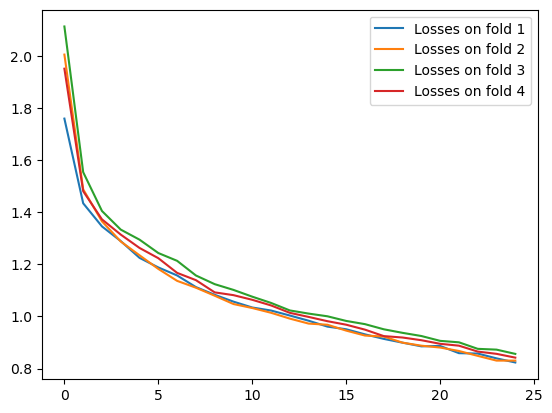

In [30]:
for i in range(4):
    plt.plot(epoch_losses[i]['losses'], label=f"Losses on fold {i + 1}")
plt.legend()
plt.show()

In [26]:
#Обучение третьей модели

kf = KFold(n_splits=4)
epoch_losses = {}
verbose = 5
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    torch.cuda.empty_cache()
    hidden_sizes = [512]
    model = MyCNNModel2(3, 8).cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) 
    train_dataset = MyDataset(X_train.iloc[train_index], y_train.iloc[train_index], transform=transform, device='cuda:0')
    validate_dataset = MyDataset(X_train.iloc[test_index], y_train.iloc[test_index], transform=transform, device='cpu')
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=16, shuffle=False)
    
    epochs = 25
    epoch_loss = []
    
    start_time = time.time()
    print(f'Fold {i+1}')
    for epoch in range(epochs):
        
        val_losses = []
        temp_loss = 0
        
        losses = []
        model.train()
        for X, y in tqdm(train_loader, desc=f'Epoch {epoch+1}', position=0, leave=False):
            optimizer.zero_grad()  
            y_pred = model.to('cuda:0').forward(X)        
            curr_loss = criterion(y_pred, y)
            losses.append(curr_loss)
            curr_loss.backward()
            optimizer.step()   

            val_losses.append(curr_loss.item())
            torch.cuda.empty_cache()

        if epoch % verbose == 0:
            with torch.no_grad():
                model.eval()
                y_pred = torch.tensor([])
                y_true = torch.tensor([])
                for X, y in tqdm(validate_loader, desc='Validate', leave=False):
                    pred = model.to('cpu').forward(X)
                    curr_loss = criterion(pred, y).item()
                    y_pred = torch.hstack((y_pred, pred.argmax(dim=1)))
                    y_true = torch.hstack((y_true, y.to('cpu')))
                    
                print(f"Epoch {epoch+1} | Loss: {curr_loss} | Accuracy: {accuracy_score(y_true, y_pred)} | F1-score {f1_score(y_true, y_pred, average='weighted')}")
                
        temp_loss = sum(val_losses) / len(val_losses)
        epoch_loss.append(temp_loss)
    fold_time = time.time() - start_time
    epoch_losses[i] = {'losses': epoch_loss, 'time': fold_time}

Fold 1


Epoch 1 | Loss: 1.0649573802947998 | Accuracy: 0.37228319345814503 | F1-score 0.32927655834871405


Epoch 6 | Loss: 0.4862675666809082 | Accuracy: 0.5700451904454487 | F1-score 0.552745697935645


Epoch 11 | Loss: 0.2526851296424866 | Accuracy: 0.6163115988809985 | F1-score 0.6032287814813594


Epoch 16 | Loss: 0.2803100347518921 | Accuracy: 0.6460081773187002 | F1-score 0.6346998163368684


Epoch 21 | Loss: 0.3532112240791321 | Accuracy: 0.6664514740692921 | F1-score 0.664044077885988


Fold 2


Epoch 1 | Loss: 1.5069276094436646 | Accuracy: 0.3118140735958683 | F1-score 0.24260686450041324


Epoch 6 | Loss: 1.3455259799957275 | Accuracy: 0.5545513234344739 | F1-score 0.5394029412273421


Epoch 11 | Loss: 0.6853601336479187 | Accuracy: 0.6126533247256294 | F1-score 0.6108561972866603


Epoch 16 | Loss: 0.6922093033790588 | Accuracy: 0.6348181622552184 | F1-score 0.6354610305786951


Epoch 21 | Loss: 0.4871635437011719 | Accuracy: 0.6453625995265763 | F1-score 0.6464169525368922


Fold 3


Epoch 1 | Loss: 1.6381295919418335 | Accuracy: 0.27981058975462764 | F1-score 0.2295911093823687


Epoch 6 | Loss: 1.1079789400100708 | Accuracy: 0.5374515712440809 | F1-score 0.5294474281788764


Epoch 11 | Loss: 1.3467912673950195 | Accuracy: 0.5916917778734395 | F1-score 0.5865252364297994


Epoch 16 | Loss: 1.6250823736190796 | Accuracy: 0.623331898407232 | F1-score 0.6152530839591801


Epoch 21 | Loss: 1.05270254611969 | Accuracy: 0.6597072750753337 | F1-score 0.6572272301106329


Fold 4


Epoch 1 | Loss: 1.5869274139404297 | Accuracy: 0.3553594489883771 | F1-score 0.3361332786060195


Epoch 6 | Loss: 1.0328186750411987 | Accuracy: 0.5322858372793801 | F1-score 0.5226961683291724


Epoch 11 | Loss: 1.192117691040039 | Accuracy: 0.6140766250538098 | F1-score 0.6131724024848619


Epoch 16 | Loss: 0.8532060980796814 | Accuracy: 0.646147223417994 | F1-score 0.6423374367213985


Epoch 21 | Loss: 1.1016879081726074 | Accuracy: 0.6549720189410245 | F1-score 0.6487590234118467


In [32]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model.to('cpu')(X)
        predicted = torch.argmax(outputs, dim=1)
        y_pred += list(predicted.cpu().numpy())
        y_true += list(y)

In [28]:
accuracy = accuracy_score(list(map(lambda x: x.cpu(), y_true)), y_pred)
print(f"Accuracy on test data: {accuracy}")
f1 = f1_score(list(map(lambda x: x.cpu(), y_true)), y_pred, average='weighted')
print(f"F1 on test data: {f1}")

Accuracy on test data: 0.6615020443296751
F1 on test data: 0.6612348300439381


In [34]:
print(f'Среднее время обучения: {sum([epoch_losses[key]["time"] for key in range(4)])/4/60:.2f} минут')

Среднее время обучения: 30.32 минут


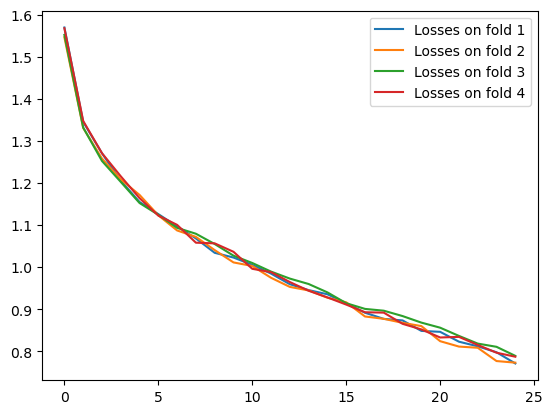

In [35]:
for i in range(4):
    plt.plot(epoch_losses[i]['losses'], label=f"Losses on fold {i + 1}")
plt.legend()
plt.show()

In [14]:
#Скачка предобученной модели

import timm
model = timm.create_model('efficientformerv2_l', pretrained=True, in_chans=3, num_classes=8)

In [15]:
model.default_cfg

{'url': '',
 'hf_hub_id': 'timm/efficientformerv2_l.snap_dist_in1k',
 'architecture': 'efficientformerv2_l',
 'tag': 'snap_dist_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'stem.conv1.conv',
 'classifier': ('head', 'head_dist')}

In [16]:
model = model.cuda()

In [17]:
train_dataset = MyDataset(X_train, y_train, transform=transform, device='cuda:0')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) 

In [19]:
#Обучение EfficientNet

epochs = 25
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    val_losses = []
    temp_loss = 0
    
    losses = []
    for X, y in tqdm(train_loader):
        optimizer.zero_grad()  
        y_pred = model.forward(X)        
        curr_loss = criterion(y_pred, y)
        losses.append(curr_loss)
        curr_loss.backward()
        optimizer.step()   
        
        val_losses.append(curr_loss.item())
    
    temp_loss = sum(val_losses) / len(val_losses)
    epoch_loss.append(temp_loss)
    print(f"Epoch {epoch+1} loss: {temp_loss}")
efficient_time = time.time() - start_time

100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:32<00:00,  2.27it/s]


Epoch 1 loss: 1.1652281788817371


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:04<00:00,  2.13it/s]


Epoch 2 loss: 0.9704666819404202


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:09<00:00,  2.12it/s]


Epoch 3 loss: 0.8983751002205423


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:02<00:00,  2.14it/s]


Epoch 4 loss: 0.8533221004905881


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:02<00:00,  2.14it/s]


Epoch 5 loss: 0.8144190103431167


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:59<00:00,  2.15it/s]


Epoch 6 loss: 0.7724020284522011


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:57<00:00,  2.16it/s]


Epoch 7 loss: 0.7446030133023935


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:02<00:00,  2.14it/s]


Epoch 8 loss: 0.7016650747103863


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:07<00:00,  2.12it/s]


Epoch 9 loss: 0.6681275473019548


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:03<00:00,  2.14it/s]


Epoch 10 loss: 0.6271182036543467


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:02<00:00,  2.14it/s]


Epoch 11 loss: 0.5913763241954597


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:57<00:00,  2.16it/s]


Epoch 12 loss: 0.5502414390662759


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:57<00:00,  2.16it/s]


Epoch 13 loss: 0.5112290321793183


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:55<00:00,  2.17it/s]


Epoch 14 loss: 0.4736605520631073


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:56<00:00,  2.17it/s]


Epoch 15 loss: 0.42782002469451


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:00<00:00,  2.15it/s]


Epoch 16 loss: 0.40430335840290466


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [09:00<00:00,  2.15it/s]


Epoch 17 loss: 0.3738161822582199


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:55<00:00,  2.17it/s]


Epoch 18 loss: 0.33546208184718984


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:54<00:00,  2.18it/s]


Epoch 19 loss: 0.31642167235880114


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:52<00:00,  2.18it/s]


Epoch 20 loss: 0.281366534621684


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:56<00:00,  2.17it/s]


Epoch 21 loss: 0.26401786029534396


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:57<00:00,  2.16it/s]


Epoch 22 loss: 0.24755519932527062


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:57<00:00,  2.16it/s]


Epoch 23 loss: 0.2432133440535817


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:55<00:00,  2.17it/s]


Epoch 24 loss: 0.22033126259915106


100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [08:54<00:00,  2.17it/s]

Epoch 25 loss: 0.2107485360914774


In [20]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in tqdm(test_loader):
        outputs = model.cpu()(X)
        predicted = torch.argmax(outputs, dim=1)
        y_pred += list(predicted.cpu().numpy())
        y_true += list(y)

100%|████████████████████████████████████████████████████████████████████████████████| 291/291 [08:40<00:00,  1.79s/it]


In [21]:
accuracy = accuracy_score(list(map(lambda x: x.cpu(), y_true)), y_pred)
print(f"Accuracy on test data: {accuracy}")
f1 = f1_score(list(map(lambda x: x.cpu(), y_true)), y_pred, average='weighted')
print(f"F1 on test data: {f1}")

Accuracy on test data: 0.6804389928986443
F1 on test data: 0.6803469238623863


In [1]:
print(f'Время обучения: {efficient_time/60:.2f} минут')

Время обучения: 224.64 минут


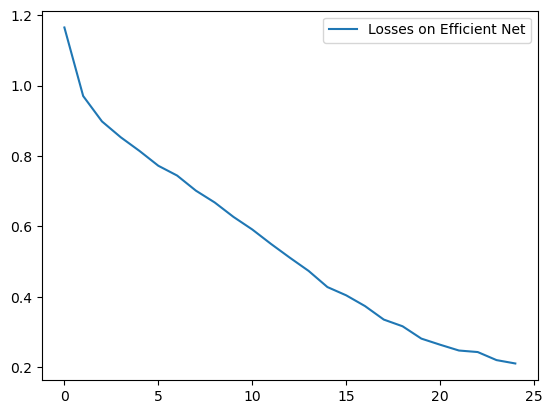

In [23]:
plt.plot(epoch_loss, label=f"Losses on Efficient Net")
plt.legend()
plt.show()

In [22]:
model = torch.load('model.pth')

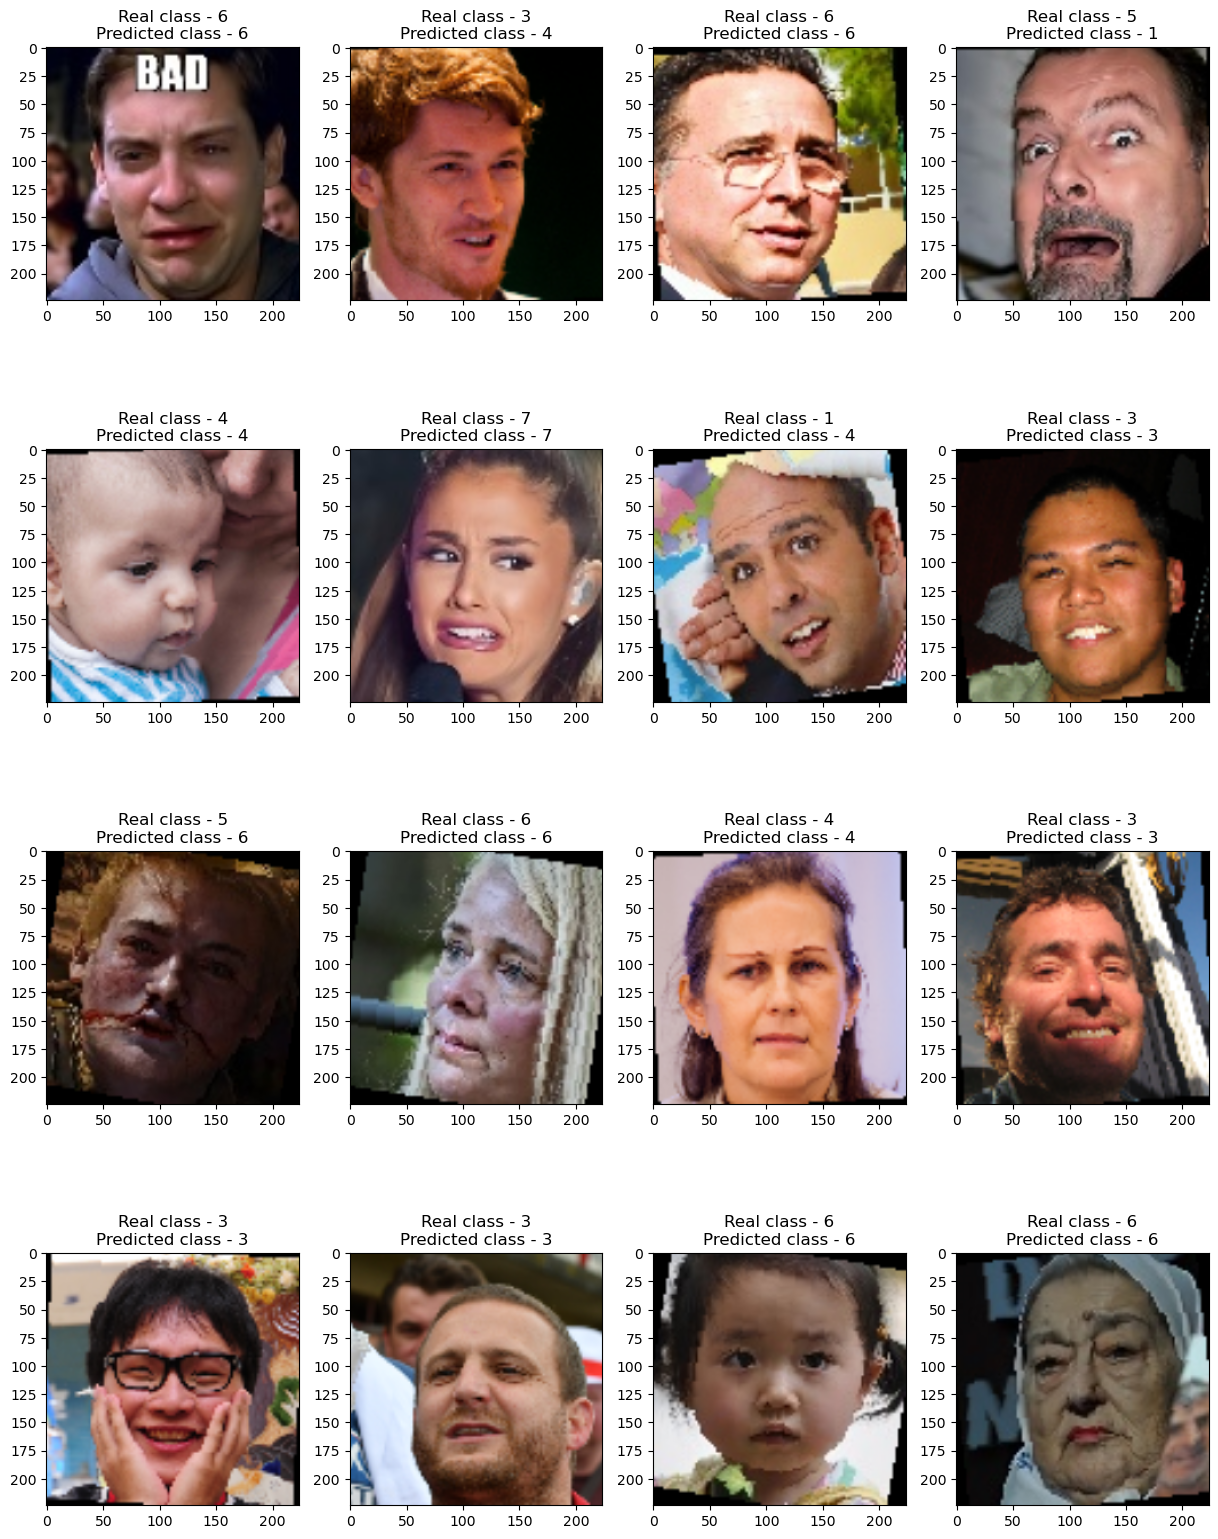

In [32]:
#Визуализация работы оптимальной сети

viz_x, viz_y = next(iter(test_loader))
viz_pred = model.cpu()(viz_x).argmax(dim=1)
fig, axes = plt.subplots(4, 4, figsize=(15, 20))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(viz_x[i*4+j].permute(1, 2, 0))
        axes[i, j].set_title(f'Real class - {viz_y[i*4+j]}\nPredicted class - {viz_pred[i*4+j]}')